### 데이터 로드

In [2]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import probplot, bartlett, levene
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import jarque_bera
import pandasql as ps

df = fdr.DataReader('KS11','2014','2022-05-09')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,2013.109985,2013.890015,1967.189941,1967.189941,1967.189941,207800.0
2014-01-03,1963.719971,1964.630005,1936.150024,1946.140015,1946.140015,188500.0
2014-01-06,1947.619995,1961.849976,1943.739990,1953.280029,1953.280029,193600.0
2014-01-07,1947.650024,1965.739990,1947.079956,1959.439941,1959.439941,193000.0
2014-01-08,1965.500000,1966.949951,1950.020020,1958.959961,1958.959961,217100.0
...,...,...,...,...,...,...
2022-04-29,2669.179932,2696.100098,2664.060059,2695.050049,2695.050049,975000.0
2022-05-02,2669.209961,2689.909912,2667.850098,2687.449951,2687.449951,873400.0
2022-05-03,2690.159912,2702.100098,2680.459961,2680.459961,2680.459961,883100.0


In [3]:
data = pd.DataFrame(df['Close'])
data.isnull().sum()

Close    1
dtype: int64

In [4]:
data = data.interpolate()
data.isnull().sum()

Close    0
dtype: int64

In [5]:
data_2013 = fdr.DataReader('KS11','2013-12-30','2014-01-03')
data_2013

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-30,2004.319946,2011.339966,1998.609985,2011.339966,2011.339966,172200
2014-01-02,2013.109985,2013.890015,1967.189941,1967.189941,1967.189941,207800


In [6]:
data = data.rename(columns = {"Close":'당일종가'})
data['전일종가'] = data['당일종가'].shift()
data['전일종가'][0] = data_2013[data_2013.index == '2013-12-30']['Close'] # 결측치 제거를 위해 2013년 마지막 날 코스피 종가 데이터 입력
data

,당일종가,전일종가
Date,,
2014-01-02,1967.189941,2011.339966
2014-01-03,1946.140015,1967.189941
2014-01-06,1953.280029,1946.140015
2014-01-07,1959.439941,1953.280029
2014-01-08,1958.959961,1959.439941
...,...,...
2022-04-29,2695.050049,2667.489990
2022-05-02,2687.449951,2695.050049
2022-05-03,2680.459961,2687.449951


In [7]:
new_order = ['전일종가','당일종가']
data = data[new_order]
data['change'] = data['당일종가']/data['전일종가']
data

C:\Users\이동현\AppData\Local\Temp\ipykernel_15660\2874607138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['change'] = data['당일종가']/data['전일종가']


,전일종가,당일종가,change
Date,,,
2014-01-02,2011.339966,1967.189941,0.978049
2014-01-03,1967.189941,1946.140015,0.989299
2014-01-06,1946.140015,1953.280029,1.003669
2014-01-07,1953.280029,1959.439941,1.003154
2014-01-08,1959.439941,1958.959961,0.999755
...,...,...,...
2022-04-29,2667.489990,2695.050049,1.010332
2022-05-02,2695.050049,2687.449951,0.997180
2022-05-03,2687.449951,2680.459961,0.997399


### 시계열 분석을 위한 검증 Class


ADF Test Results

ADF Statistic: -29.241567679691233
p-value: 0.0
Critical Values: {'1%': -3.433547028919612, '5%': -2.8629522934224085, '10%': -2.5675218415927885}
Is data stationary?: Yes


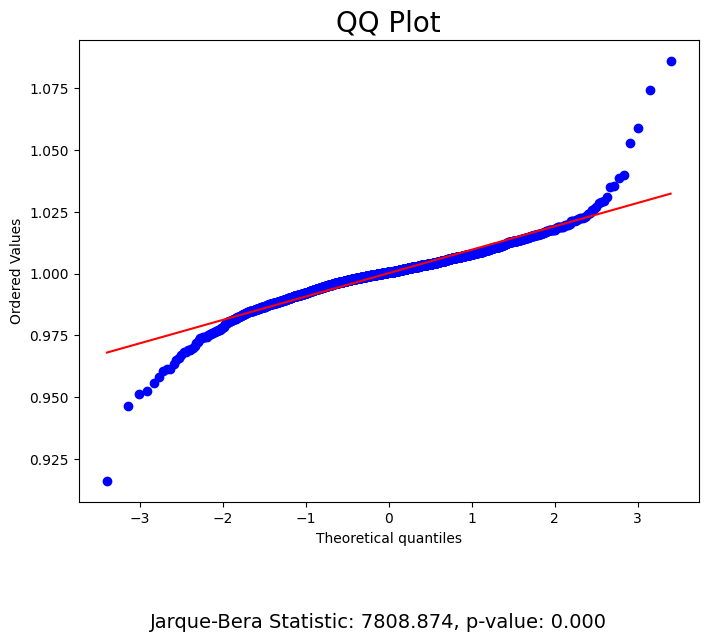

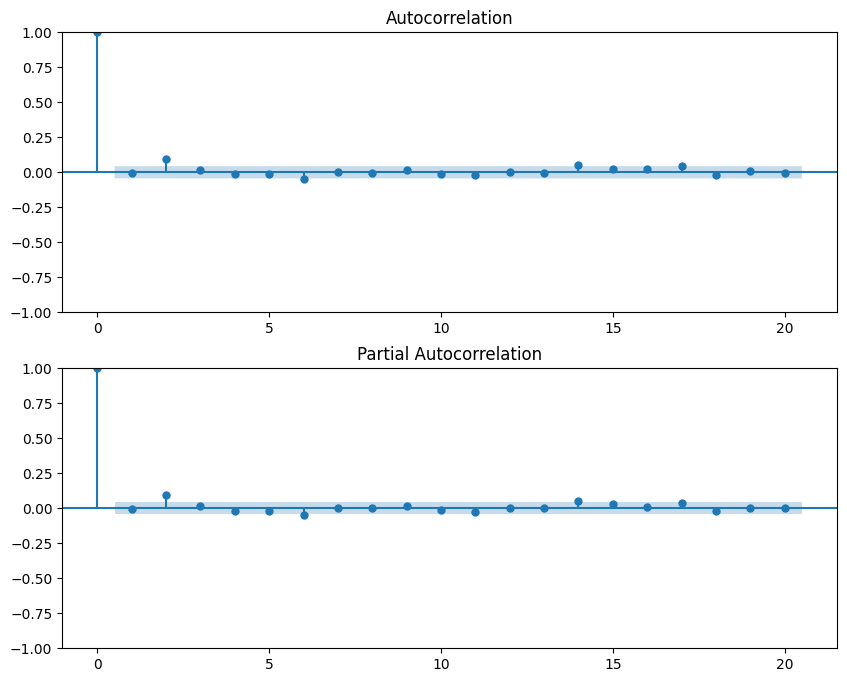


Homoscedasticity Test Results

Test used: Levene Test
Test p-value: 8.226633273093579e-22
Equal variance? No


In [8]:
class TimeSeriesTester:
    def __init__(self, data):
        self.data = data

    def plot_qq_plot(self):
        plt.figure(figsize=(8, 6))
        probplot(self.data, dist='norm', plot=plt)

        # Jarque-Bera Test for normality
        jb_stat, jb_pvalue = jarque_bera(self.data)
        jb_result = f"Jarque-Bera Statistic: {jb_stat:.3f}, p-value: {jb_pvalue:.3f}"
        # Plot title and result
        plt.title("QQ Plot", fontsize=20)
        plt.figtext(0.5, -0.1, jb_result, ha='center', fontsize=14)
        plt.show()

    def plot_acf_pacf(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        plot_acf(self.data, ax=ax1, lags=20)
        plot_pacf(self.data, ax=ax2, lags=20)
        plt.show()

    def test_stationarity(self):
        adf_result = adfuller(self.data)
        adf_test_results = {
            "ADF Statistic": adf_result[0],
            "p-value": adf_result[1],
            "Critical Values": adf_result[4],
            "Is data stationary?": "Yes" if adf_result[1] <= 0.05 else "No"}
        print("\nADF Test Results\n")
        for key, value in adf_test_results.items():
            print(f"{key}: {value}")

    def test_homoscedasticity(self):
        n = len(self.data)
        group1 = self.data[:n // 2]
        group2 = self.data[n // 2:]

        # Jarque-Bera Test for normality
        jb_test = jarque_bera(self.data)
        is_normal = jb_test[1] > 0.05

        if is_normal:
            homoscedasticity_result = bartlett(group1, group2)
            test_name = 'Bartlett Test'
        else:
            homoscedasticity_result = levene(group1, group2)
            test_name = 'Levene Test'

        equal_variance = homoscedasticity_result.pvalue > 0.05
        print("\nHomoscedasticity Test Results\n")
        print("Test used:", test_name)
        print("Test p-value:", homoscedasticity_result.pvalue)
        print("Equal variance?", "Yes" if equal_variance else "No")

# 클래스 인스턴스 생성 
tester = TimeSeriesTester(data['change']) 

tester.test_stationarity()
tester.plot_qq_plot() # This will also print Jarque-Bera Test results
tester.plot_acf_pacf()
tester.test_homoscedasticity()

- 코스피의 변동률은 white noise 형태를 보이므로, 분석 불가

- 이전에 실패했던 원인을 찾았으니, 코스피의 종가 데이터로 리뷰 진행

### 코스피의 당일 종가 분석

In [9]:
df = fdr.DataReader('KS11','2014','2022-05-09')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,2013.109985,2013.890015,1967.189941,1967.189941,1967.189941,207800.0
2014-01-03,1963.719971,1964.630005,1936.150024,1946.140015,1946.140015,188500.0
2014-01-06,1947.619995,1961.849976,1943.739990,1953.280029,1953.280029,193600.0
2014-01-07,1947.650024,1965.739990,1947.079956,1959.439941,1959.439941,193000.0
2014-01-08,1965.500000,1966.949951,1950.020020,1958.959961,1958.959961,217100.0
...,...,...,...,...,...,...
2022-04-29,2669.179932,2696.100098,2664.060059,2695.050049,2695.050049,975000.0
2022-05-02,2669.209961,2689.909912,2667.850098,2687.449951,2687.449951,873400.0
2022-05-03,2690.159912,2702.100098,2680.459961,2680.459961,2680.459961,883100.0


In [10]:
print(df.isnull().sum())

query = '''
select * from df
where Close is null
'''

print(ps.sqldf(query, locals())) # 임시 공휴일

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64
                         Date  Open  High   Low Close Adj Close Volume
0  2015-08-14 00:00:00.000000  None  None  None  None      None   None


In [11]:
df = df.interpolate() # 보간법 처리
print(df.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64



ADF Test Results

ADF Statistic: -1.3824791842960082
p-value: 0.5906464005193751
Critical Values: {'1%': -3.4335485926965914, '5%': -2.8629529838536296, '10%': -2.567522209209612}
Is data stationary?: No


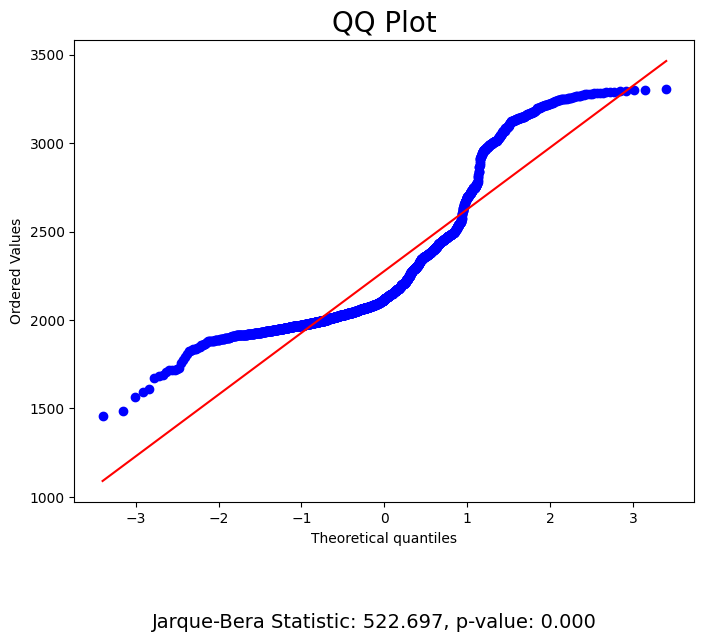

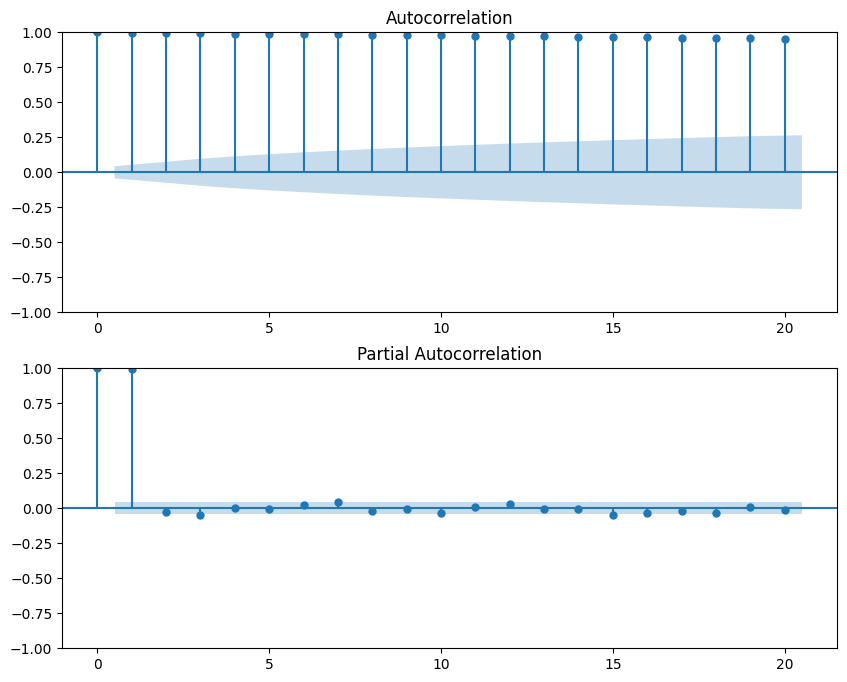


Homoscedasticity Test Results

Test used: Levene Test
Test p-value: 1.718541008948916e-103
Equal variance? No


In [12]:
tester = TimeSeriesTester(df['Close']) 

tester.test_stationarity()
tester.plot_qq_plot()
tester.plot_acf_pacf()
tester.test_homoscedasticity()


ADF Test Results

ADF Statistic: -29.82760971097414
p-value: 0.0
Critical Values: {'1%': -3.4335485926965914, '5%': -2.8629529838536296, '10%': -2.567522209209612}
Is data stationary?: Yes


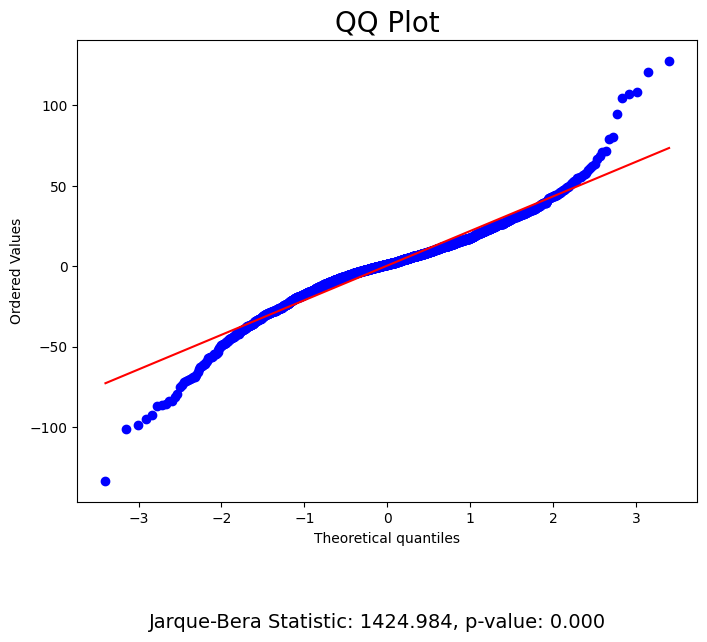

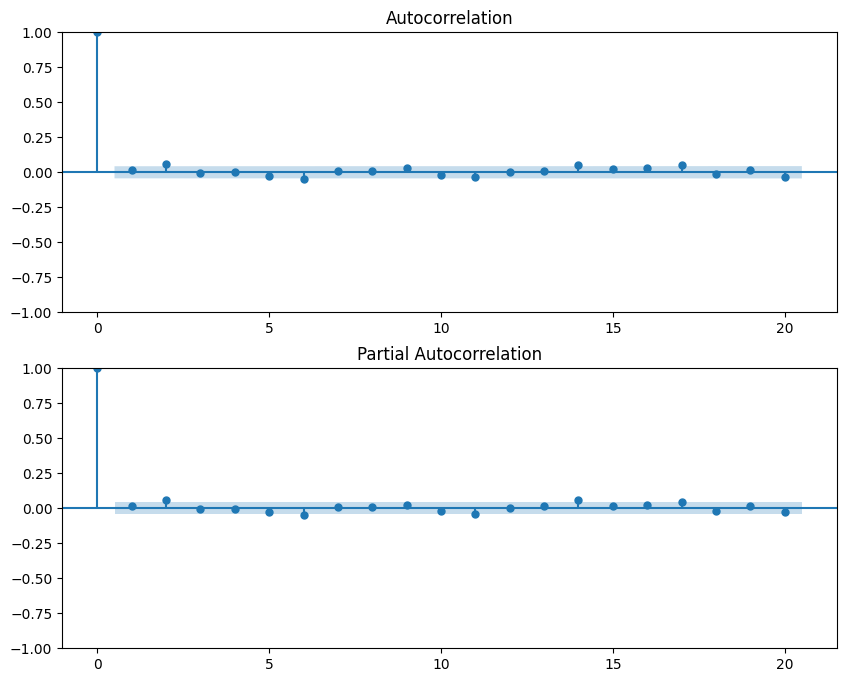


Homoscedasticity Test Results

Test used: Levene Test
Test p-value: 1.4178225375881006e-39
Equal variance? No


In [13]:
tester = TimeSeriesTester(np.diff(df['Close']))
tester.test_stationarity()
tester.plot_qq_plot()
tester.plot_acf_pacf()
tester.test_homoscedasticity()

- 동일한 문제 발생

- 코스피의 변동률 혹은 종가 단일 데이터만으로는 ARIMA 계열 모델 사용 불가

- 원문 자체를 구현하는 것으로 루트 변경

# 논문 구현 시작

## 데이터 로드 및 간단한 전처리

In [14]:
data = fdr.DataReader('KS11','2014','2023-08-13')
print(data)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2014-01-02  2013.109985  2013.890015  1967.189941  1967.189941  1967.189941   
2014-01-03  1963.719971  1964.630005  1936.150024  1946.140015  1946.140015   
2014-01-06  1947.619995  1961.849976  1943.739990  1953.280029  1953.280029   
2014-01-07  1947.650024  1965.739990  1947.079956  1959.439941  1959.439941   
2014-01-08  1965.500000  1966.949951  1950.020020  1958.959961  1958.959961   
...                 ...          ...          ...          ...          ...   
2023-08-07  2591.580078  2607.360107  2580.709961  2580.709961  2580.709961   
2023-08-08  2598.290039  2601.409912  2568.149902  2573.979980  2573.979980   
2023-08-09  2580.600098  2608.979980  2576.209961  2605.120117  2605.120117   
2023-08-10  2592.399902  2601.560059  2590.020020  2601.560059  2601.560059   
2023-08-11  2611.250000  2616.840088  2589.939941  2

In [15]:
data = data.interpolate() # 결측치 처리(2015-08-14)
data = data.rename(columns = {"Close":'당일종가'})
data['전일종가'] = data['당일종가'].shift()
data['전일종가'][0] = data_2013[data_2013.index == '2013-12-30']['Close'] # 결측치 제거를 위해 2013년 마지막 날 코스피 종가 데이터 입력
data['change'] = data['당일종가']/data['전일종가']
data['change'] = np.log(data['change'])

## 간단한 EDA


ADF Test Results

ADF Statistic: -10.485381379289619
p-value: 1.1841180828569887e-18
Critical Values: {'1%': -3.433150040278986, '5%': -2.862777005249994, '10%': -2.567428512170331}
Is data stationary?: Yes


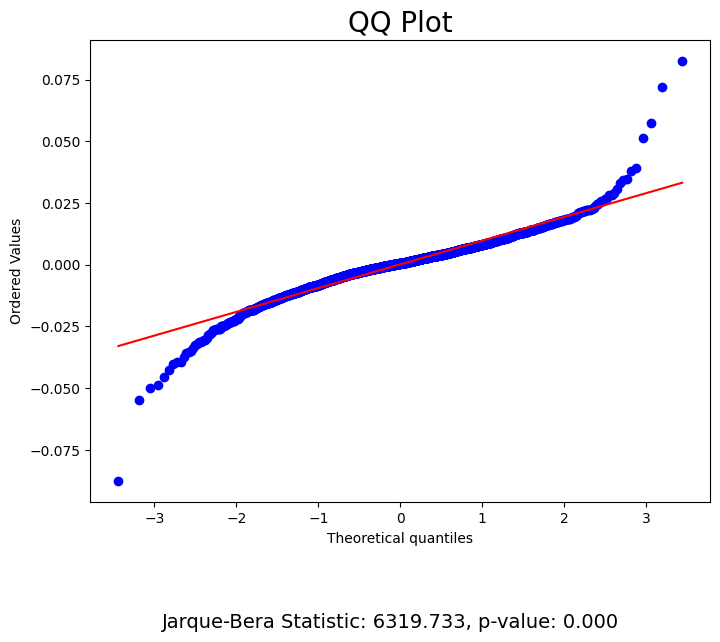

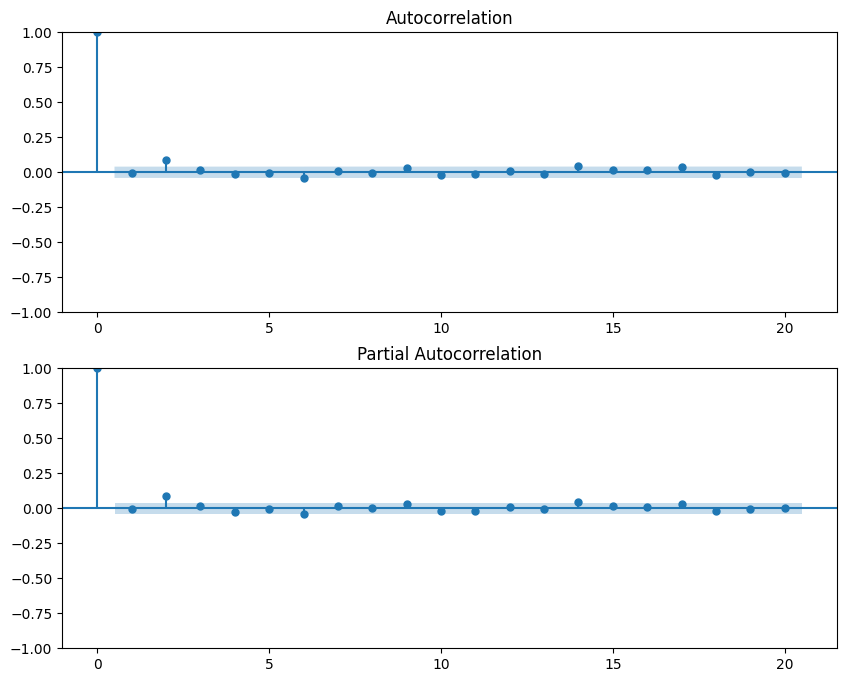


Homoscedasticity Test Results

Test used: Levene Test
Test p-value: 4.048949063315459e-26
Equal variance? No


In [16]:
# 클래스 인스턴스 생성 
tester = TimeSeriesTester(data['change']) 

tester.test_stationarity()
tester.plot_qq_plot() # This will also print Jarque-Bera Test results
tester.plot_acf_pacf()
tester.test_homoscedasticity()

- 신뢰도 상한 및 하한을 넘는 시차 : 2, 6, 14

- 사용할 데이터 : t ~ t-6일간의 변동률(과거 8일 데이터)

In [17]:
inp = data[['change']]
print(inp)

              change
Date                
2014-01-02 -0.022195
2014-01-03 -0.010758
2014-01-06  0.003662
2014-01-07  0.003149
2014-01-08 -0.000245
...              ...
2023-08-07 -0.008523
2023-08-08 -0.002611
2023-08-09  0.012025
2023-08-10 -0.001367
2023-08-11 -0.003967

[2364 rows x 1 columns]


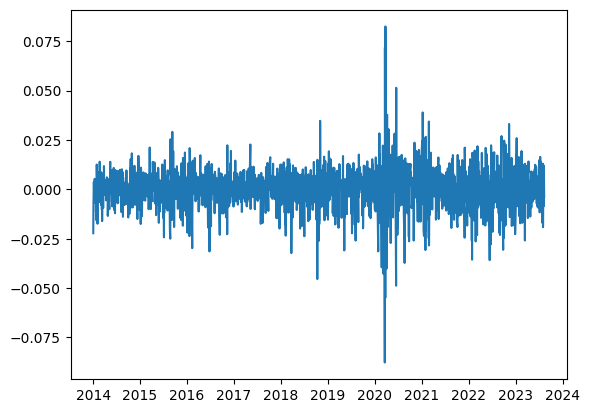

In [132]:
import matplotlib.pyplot as plt

plt.plot(inp)

In [18]:
train = inp.iloc[:int(len(inp)*0.8)]
test = inp.iloc[int(len(inp)*0.8):]

print(train, test, sep = '\n\n')

              change
Date                
2014-01-02 -0.022195
2014-01-03 -0.010758
2014-01-06  0.003662
2014-01-07  0.003149
2014-01-08 -0.000245
...              ...
2021-09-02 -0.009767
2021-09-03  0.007907
2021-09-06  0.000709
2021-09-07 -0.004979
2021-09-08 -0.007694

[1891 rows x 1 columns]

              change
Date                
2021-09-09 -0.015385
2021-09-10  0.003545
2021-09-13  0.000672
2021-09-14  0.006682
2021-09-15  0.001450
...              ...
2023-08-07 -0.008523
2023-08-08 -0.002611
2023-08-09  0.012025
2023-08-10 -0.001367
2023-08-11 -0.003967

[473 rows x 1 columns]


## train/val/test data

### train, val data

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

x = []
y_up = []
y_down = []

for i in range(len(train)-7):
    x.append(train['change'].values[i:i+7])
    change_next = train['change'].values[i+7]
    y_up.append(1 if change_next >= 0.007 else 0)
    y_down.append(1 if change_next <= -0.007 else 0)
    
x = np.array(x)
y_up = np.array(y_up)
y_down = np.array(y_down)

x_train, x_val, y_up_train, y_up_val, y_down_train, y_down_val = train_test_split(x, y_up, y_down,test_size = 0.3, random_state = 42)

print(x_train, y_up_train, y_down_train, sep = '\n\n')

[[-0.01289502 -0.00567734 -0.01001272 ... -0.00606651  0.01861457
   0.01341132]
 [ 0.00336436 -0.00296165 -0.00011569 ... -0.00047393 -0.00859268
  -0.00444896]
 [ 0.00174908  0.00942004  0.00243292 ... -0.00344216 -0.00787069
  -0.0007766 ]
 ...
 [ 0.00548317 -0.00161667  0.00112402 ...  0.00328383 -0.00022614
  -0.00333074]
 [ 0.01495677  0.01527558 -0.00096814 ... -0.00041906  0.00081982
   0.003463  ]
 [ 0.00767026 -0.00051591  0.00595638 ...  0.00098151 -0.00912245
  -0.01515733]]

[0 0 1 ... 0 0 0]

[0 0 0 ... 0 0 0]


### test data

In [92]:
x = []
y_up = []
y_down = []

for i in range(len(test)-7):
    x.append(test['change'].values[i:i+7])
    change_next = test['change'].values[i+7]
    y_up.append(1 if change_next >= 0.007 else 0)
    y_down.append(1 if change_next <= -0.007 else 0)
    
x_test = np.array(x)
y_up_test = np.array(y_up)
y_down_test = np.array(y_down)

print(x_test, y_up_test, y_down_test, sep = '\n\n')

[[-0.01538496  0.00354463  0.00067164 ...  0.00145022 -0.00741942
   0.00332342]
 [ 0.00354463  0.00067164  0.00668188 ... -0.00741942  0.00332342
  -0.00412564]
 [ 0.00067164  0.00668188  0.00145022 ...  0.00332342 -0.00412564
  -0.00074849]
 ...
 [ 0.00925802  0.01301613 -0.01915445 ... -0.00099453 -0.00852327
  -0.00261121]
 [ 0.01301613 -0.01915445 -0.00424373 ... -0.00852327 -0.00261121
   0.01202545]
 [-0.01915445 -0.00424373 -0.00099453 ... -0.00261121  0.01202545
  -0.0013675 ]]

[0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0
 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0
 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 

## Modeling

### RF

In [21]:
clf_up = RandomForestClassifier()
clf_up.fit(x_train, y_up_train)

clf_down = RandomForestClassifier()
clf_down.fit(x_train, y_down_train)

y_up_pred = clf_up.predict(x_val)
y_down_pred = clf_down.predict(x_val)

accuracy_up = accuracy_score(y_up_val, y_up_pred)
accuracy_down = accuracy_score(y_down_val, y_down_pred)

precision_up = precision_score(y_up_val, y_up_pred)
precision_down = precision_score(y_down_val, y_down_pred)

print(accuracy_up, accuracy_down)
print(precision_up, precision_down)

0.8091872791519434 0.8480565371024735
0.3888888888888889 0.2727272727272727


In [ ]:
# Grid Search

param_grid = {
    'n_estimators': list(range(2, 11, 1)),
    'max_depth': list(range(2, 16, 1)),
    'min_samples_split': list(range(5, 26, 1)),
    'min_samples_leaf': list(range(2, 11, 1))
} 

clf_up_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, n_jobs=1)
clf_up_grid.fit(x_train, y_up_train)
best_params_up = clf_up_grid.best_params_

# Grid search for the downward trend model
clf_down_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, n_jobs=1)
clf_down_grid.fit(x_train, y_down_train)
best_params_down = clf_down_grid.best_params_

print(best_params_up, best_params_down, sep='\n\n')

### SVM, MLP, LGBM, XGB

In [137]:
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

clf_rf = RandomForestClassifier()
clf_svm = SVC(kernel = 'poly')
clf_lgbm = LGBMClassifier()
clf_xgb = XGBClassifier()
clf_mlp = MLPClassifier() 


classifiers = {
    'RF' : clf_rf,
    'SVM' : clf_svm,
    'LGBM': clf_lgbm,
    'XGB': clf_xgb,
    'MLP': clf_mlp
}

results_up = {'Model':[], 'Accuracy':[], 'Precision':[]}
results_down = {'Model':[], 'Accuracy':[], 'Precision':[]}

for name, clf in classifiers.items():
    
    # 상승 모델
    clf.fit(x_train, y_up_train)
    y_up_pred = clf.predict(x_val)
    accuracy_up = accuracy_score(y_up_val, y_up_pred)
    precision_up = precision_score(y_up_val, y_up_pred)
    results_up['Model'].append(name)
    results_up['Accuracy'].append(accuracy_up)
    results_up['Precision'].append(precision_up)
    
    # 하락 모델
    clf.fit(x_train, y_down_train)
    y_up_pred = clf.predict(x_val)
    accuracy_up = accuracy_score(y_up_val, y_up_pred)
    precision_up = precision_score(y_up_val, y_up_pred)
    results_down['Model'].append(name)
    results_down['Accuracy'].append(accuracy_up)
    results_down['Precision'].append(precision_up)

[LightGBM] [Info] Number of positive: 244, number of negative: 1074
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1318, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.185129 -> initscore=-1.481977
[LightGBM] [Info] Start training from score -1.481977
[LightGBM] [Info] Number of positive: 232, number of negative: 1086
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1318, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176024 -> initscore=-1.543519
[LightGBM] [Info] Start training from score -1.543519


c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [138]:
df_results_up = pd.DataFrame(results_up)
df_results_down = pd.DataFrame(results_down)

df_results_up

,Model,Accuracy,Precision
0,RF,0.809187,0.357143
1,SVM,0.812721,0.428571
2,LGBM,0.791519,0.230769
3,XGB,0.780919,0.272727
4,MLP,0.816254,0.000000


In [139]:
df_results_down

,Model,Accuracy,Precision
0,RF,0.809187,0.333333
1,SVM,0.812721,0.375000
2,LGBM,0.795053,0.227273
3,XGB,0.795053,0.285714
4,MLP,0.816254,0.000000


### hybrid

In [140]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

top3_up_models = list(df_results_up.sort_values(by='Precision', ascending = False).head(3)['Model'].values)
top3_down_models = list(df_results_down.sort_values(by='Precision', ascending = False).head(3)['Model'].values)
print(top3_up_models, top3_down_models)

['SVM', 'RF', 'XGB'] ['SVM', 'RF', 'XGB']


In [141]:
models_dict = {
    'RF': RandomForestClassifier(),
    'SVM': SVC(probability=True), # To use VotingClassifier, probability needs to be set to True for SVM
    'XGB': XGBClassifier(),
    'MLP': MLPClassifier(hidden_layer_sizes=(11,12), max_iter=430, learning_rate_init = 0.01),
    'LGBM': LGBMClassifier()
}

top3_up_classifiers = [(model, models_dict[model]) for model in top3_up_models]
top3_down_classifiers = [(model, models_dict[model]) for model in top3_down_models]

print(top3_up_classifiers)
print(top3_down_classifiers)

[('SVM', SVC(probability=True)), ('RF', RandomForestClassifier()), ('XGB', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...))]
[('SVM', SVC(probability=True)), ('RF', RandomForestClassifier()), ('XGB', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=Non

In [142]:
hybrid_results_up = {'Model':[], 'Accuracy':[], 'Precision':[]}
hybrid_results_down = {'Model':[], 'Accuracy':[], 'Precision':[]}

# Voting
voting_clf_up = VotingClassifier(estimators=top3_up_classifiers, voting='soft')
voting_clf_down = VotingClassifier(estimators=top3_down_classifiers, voting='soft')

# Weighted Voting
weights = [0.33, 0.33, 0.34]
voting_weighted_clf_up = VotingClassifier(estimators=top3_up_classifiers, voting='soft', weights=weights)
voting_weighted_clf_down = VotingClassifier(estimators=top3_down_classifiers, voting='soft', weights=weights)

# Stacking
stacking_clf_up = StackingClassifier(estimators=top3_up_classifiers, final_estimator=LogisticRegression())
stacking_clf_down = StackingClassifier(estimators=top3_down_classifiers, final_estimator=LogisticRegression())

extended_classifiers = {
    'Voting_Up': voting_clf_up,
    'Voting_Down': voting_clf_down,
    'Weighted_Voting_Up': voting_weighted_clf_up,
    'Weighted_Voting_Down': voting_weighted_clf_down,
    'Stacking_Up': stacking_clf_up,
    'Stacking_Down': stacking_clf_down
}

for name, clf in extended_classifiers.items():
    # Check if the classifier is for upward or downward trend
    if "Up" in name:
        clf.fit(x_train, y_up_train)
        y_pred = clf.predict(x_val)
        accuracy = accuracy_score(y_up_val, y_pred)
        precision = precision_score(y_up_val, y_pred)
        hybrid_results_up['Model'].append(name)
        hybrid_results_up['Accuracy'].append(accuracy)
        hybrid_results_up['Precision'].append(precision)
    else:
        clf.fit(x_train, y_down_train)
        y_pred = clf.predict(x_val)
        accuracy = accuracy_score(y_down_val, y_pred)
        precision = precision_score(y_down_val, y_pred)
        hybrid_results_down['Model'].append(name)
        hybrid_results_down['Accuracy'].append(accuracy)
        hybrid_results_down['Precision'].append(precision)

hybrid_results_up_df = pd.DataFrame(hybrid_results_up)
hybrid_results_down_df = pd.DataFrame(hybrid_results_down)

c:\Users\이동현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
print(df_results_up, df_results_down, hybrid_results_up_df, hybrid_results_down_df, sep = '\n\n')

  Model  Accuracy  Precision
0    RF  0.809187   0.357143
1   SVM  0.812721   0.428571
2  LGBM  0.791519   0.230769
3   XGB  0.780919   0.272727
4   MLP  0.816254   0.000000

  Model  Accuracy  Precision
0    RF  0.809187   0.333333
1   SVM  0.812721   0.375000
2  LGBM  0.795053   0.227273
3   XGB  0.795053   0.285714
4   MLP  0.816254   0.000000

                Model  Accuracy  Precision
0           Voting_Up  0.805654   0.312500
1  Weighted_Voting_Up  0.802120   0.277778
2         Stacking_Up  0.819788   1.000000

                  Model  Accuracy  Precision
0           Voting_Down  0.846290   0.200000
1  Weighted_Voting_Down  0.848057   0.142857
2         Stacking_Down  0.856890   0.000000


- Stacking Up Model의 결과가 상당히 이상함

- test data에서 확인해보자

- 상승 : Stacking Model, SVM, RF

- 하락 : XGB, voting

## Test 확인

### 상승

In [144]:
stack_up_pred = stacking_clf_up.predict(x_test)
svm_up_pred = clf_svm.predict(x_test)

print(accuracy_score(stack_up_pred,y_up_test), precision_score(stack_up_pred,y_up_test))
print(accuracy_score(svm_up_pred,y_up_test), precision_score(svm_up_pred,y_up_test))

0.7660944206008584 0.03669724770642202
0.7639484978540773 0.009174311926605505


In [145]:
rf_pred = clf_rf.predict(x_test)
print(accuracy_score(rf_pred ,y_up_test), precision_score(rf_pred,y_up_test))

0.7553648068669528 0.009174311926605505


- 역시 무언가 잘못됐음을 확인할 수 있다.

### 하락

In [146]:
xgb_down_pred = clf_xgb.predict(x_test)
voting_down_pred = voting_clf_down.predict(x_test)

print(accuracy_score(xgb_down_pred ,y_up_test), precision_score(xgb_down_pred,y_up_test))
print(accuracy_score(voting_down_pred ,y_up_test), precision_score(voting_down_pred,y_up_test))

0.7360515021459227 0.07339449541284404
0.7553648068669528 0.0
